In [4]:
import numpy as np # linear algebra
import scipy as scipy
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
import dill

import keras as k
import cv2
from tqdm import tqdm


In [67]:
with open('tiffs.pkl', 'rb') as in_strm:
    all_info = dill.load(in_strm)
x_train = np.array(all_info[0], dtype=np.float64)
x_test = np.array(all_info[1], dtype=np.float64)
y_train = all_info[2]
y_test = all_info[3]
print(x_train.shape)
label_map = all_info[4]
inv_label_map = all_info[5]


(35000, 32, 32, 4)


In [ ]:
with open('basicFeatures.pkl', 'rb') as in_strm:
    features = dill.load(in_strm)

In [56]:
train_features = features[:8]
test_features = features[8:]

for i, train_feature in enumerate(train_features):
    train_feature = np.array(train_feature, dtype=np.float64)
    test_feature = np.array(test_features[i], dtype=np.float64)
    mean = np.mean(train_feature, axis = 0)
    train_feature -= mean # zero-center
    test_feature -= mean
    std = np.std(train_feature, axis = 0)
    train_feature /= std # normalize
    test_feature /= std
    train_features[i] = np.nan_to_num(train_feature)
    test_features[i] = np.nan_to_num(test_feature)
    
mean = np.mean(x_train, axis = 0)
x_train -= mean # zero-center
x_test -= mean
std = np.std(x_train, axis = 0)
x_train /= std # normalize
x_test /= std

#put into network
train_input = [x_train]
for train_feature in train_features:
    train_input.append(train_feature)

test_input = [x_test]
for test_feature in test_features:
    test_input.append(test_feature)


0


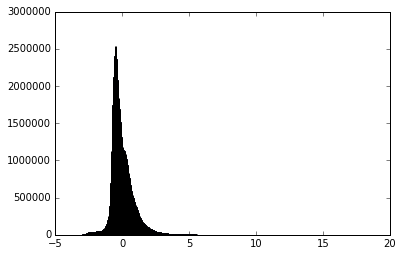

1


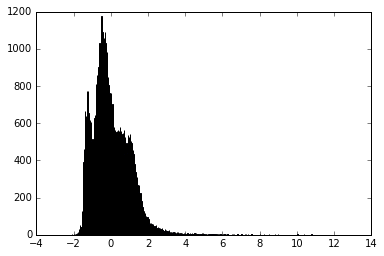

2


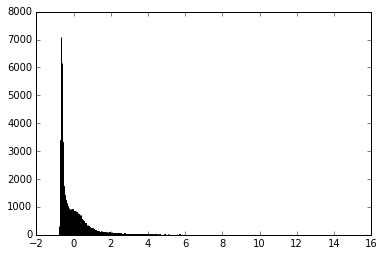

3


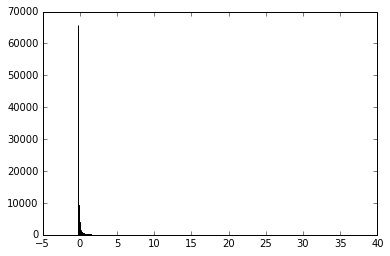

4


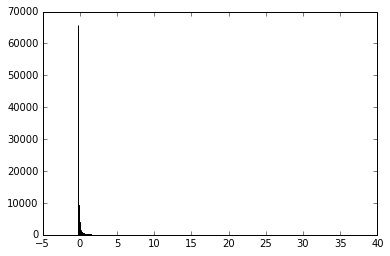

5


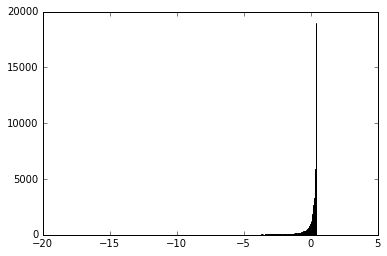

6


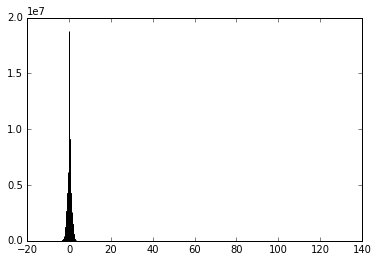

7


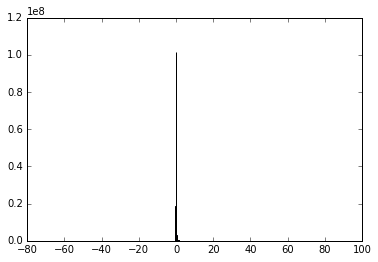

8


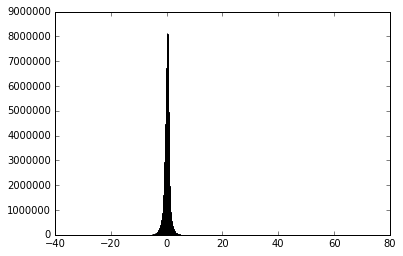

In [57]:
import matplotlib.pyplot as plt
for i, feature in enumerate(train_input):
    print(i)
    hist, bins = np.histogram(feature, bins=1000)
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.bar(center, hist, align='center', width=width)
    plt.show()

0


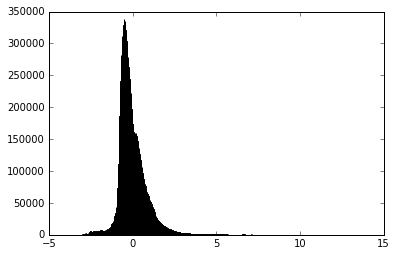

1


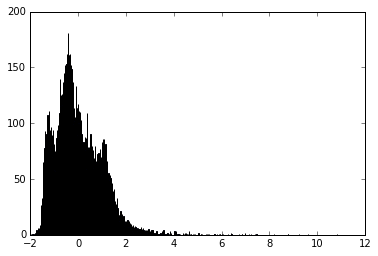

2


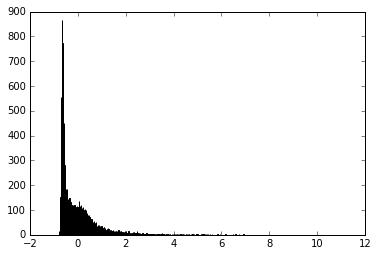

3


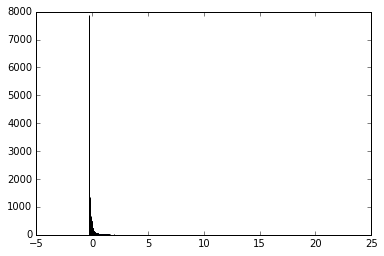

4


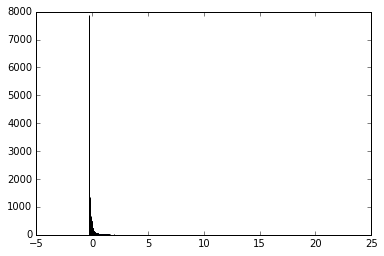

5


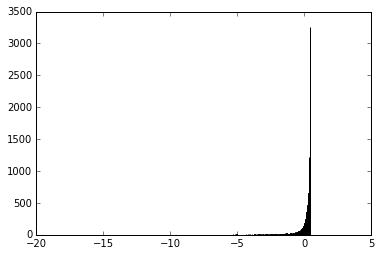

6


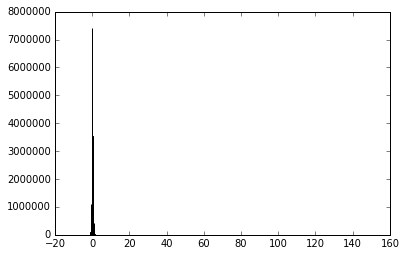

7


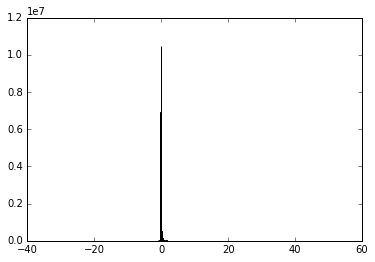

8


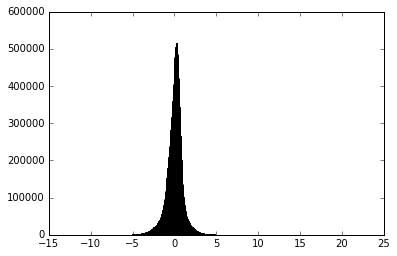

In [58]:
import matplotlib.pyplot as plt
for i, feature in enumerate(test_input):
    print(i)
    hist, bins = np.histogram(feature, bins=1000)
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.bar(center, hist, align='center', width=width)
    plt.show()

In [59]:
import gc
gc.collect()

136980

In [62]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Input, Conv2D, MaxPooling2D
from keras.models import Model
from keras.layers.merge import concatenate
from keras.optimizers import Adam

#baseline part
original_input = Input(shape=(32, 32, 4))
conv1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(original_input)
conv2 = Conv2D(64, (3, 3), activation='relu')(conv1)
max1 = MaxPooling2D(pool_size=(2, 2))(conv2)
drop1 = Dropout(0.25)(max1)
flat1 = Flatten()(drop1)
dense1 = Dense(128, activation='relu')(flat1)
drop2 = Dropout(0.5)(dense1)

#mean
mean_input = Input(shape=(4,))
#dense2 = Dense(128, activation='relu')(mean_input)

#std
std_input = Input(shape=(4,))
#dense3 = Dense(128, activation='relu')(std_input)

#var
var_input = Input(shape=(4,))
#dense4 = Dense(128, activation='relu')(var_input)

#moment
moment_input = Input(shape=(4,))
#dense5 = Dense(128, activation='relu')(moment_input)

#entropy
entropy_input = Input(shape=(4,))
#dense6 = Dense(128, activation='relu')(entropy_input)

#dct
dct_input = Input(shape=(32, 32, 4))
#conv3 = Conv2D(64, (3, 3), activation='relu')(dct_input)
flat2 = Flatten()(dct_input)

#cov
cov_input = Input(shape=(32, 32, 4))
#conv4 = Conv2D(64, (3, 3), activation='relu')(cov_input)
flat3 = Flatten()(cov_input)

#auto
auto_input = Input(shape=(32, 32, 4))
#conv5 = Conv2D(64, (3, 3), activation='relu')(auto_input)
flat4 = Flatten()(auto_input)

combine = concatenate([drop2, mean_input, std_input, var_input, 
                       moment_input, entropy_input, flat2, flat3, flat4])
dense7 = Dense(1024, activation='relu')(combine)
drop3 = Dropout(0.5)(combine)
dense8 = Dense(256, activation='relu')(drop3)
dense9 = Dense(17, activation='sigmoid')(dense8)
model = Model(inputs=[original_input, mean_input, std_input, var_input, 
                      moment_input, entropy_input, dct_input, cov_input, auto_input], outputs=dense9)

model.compile(loss='binary_crossentropy', # We NEED binary here, since categorical_crossentropy l1 norms the output before calculating loss.
                    optimizer='adam',
                    metrics=['accuracy'])


model.fit(train_input, y_train, batch_size=128, epochs=7, verbose=1, validation_data=(test_input, y_test))



Train on 35000 samples, validate on 5479 samples
Epoch 1/7
35000/35000 [==============================] - 303s - loss: 0.3051 - acc: 0.8946 - val_loss: 0.2224 - val_acc: 0.9152
Epoch 2/7
35000/35000 [==============================] - 316s - loss: 0.2225 - acc: 0.9148 - val_loss: 0.2077 - val_acc: 0.9195
Epoch 3/7
35000/35000 [==============================] - 365s - loss: 0.2106 - acc: 0.9180 - val_loss: 0.1963 - val_acc: 0.9228
Epoch 4/7
35000/35000 [==============================] - 343s - loss: 0.2020 - acc: 0.9217 - val_loss: 0.1881 - val_acc: 0.9261
Epoch 5/7
35000/35000 [==============================] - 332s - loss: 0.1929 - acc: 0.9253 - val_loss: 0.1775 - val_acc: 0.9306
Epoch 6/7
35000/35000 [==============================] - 360s - loss: 0.1861 - acc: 0.9282 - val_loss: 0.1743 - val_acc: 0.9322
Epoch 7/7
35000/35000 [==============================] - 416s - loss: 0.1816 - acc: 0.9303 - val_loss: 0.1670 - val_acc: 0.9359


In [64]:
from sklearn.metrics import fbeta_score

p_valid = model.predict(test_input, batch_size=128)
print(y_test)
print(p_valid)
print(fbeta_score(y_test, np.array(p_valid) > 0.2, beta=2, average='samples'))

[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 1 0]
 [0 0 1 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 1 0]
 [0 0 0 ..., 0 0 0]]
[[  8.40989856e-08   2.01736126e-14   0.00000000e+00 ...,   0.00000000e+00
    4.05825034e-07   0.00000000e+00]
 [  2.42082328e-01   1.33277681e-02   4.02283102e-01 ...,   6.19853335e-03
    3.85790944e-01   5.79910055e-02]
 [  3.73369664e-01   1.64329842e-01   5.87628961e-01 ...,   5.90649317e-04
    4.34476316e-01   6.46172389e-02]
 ..., 
 [  5.19007325e-01   1.37305304e-01   3.14747363e-01 ...,   3.57353175e-03
    6.81014597e-01   1.79385900e-01]
 [  3.46267492e-01   5.67365671e-03   2.13370457e-01 ...,   3.13925761e-04
    6.68346763e-01   1.13440879e-01]
 [  2.63738539e-02   1.19774224e-04   1.04615062e-01 ...,   1.37338135e-03
    8.47387686e-02   1.78512197e-03]]
0.84273048465


about a 0.04 increase! yay. 

In [66]:
model.save('baseline_with_features.h5')

Just kidding, I am so bad at Python...I'm so sorry computer. See this example:

In [ ]:
a = [1, 2]
b = [3, 4]
lst = [a, b]
a = [5, 6]
print(lst)

You will get:
[[1, 2], [3, 4]]
Because you create a NEW LIST [5, 6] that a points to.
But lst will still be pointing to [1, 2] and [5, 6]
See pythontutor. fml. 

In [ ]:
Another example:
a = [1, 2]
b = [3, 4]
lst = [a, b]
lst[0] = [5, 6]
print(a)

you will get: [1, 2]
because a still points to [1, 2]

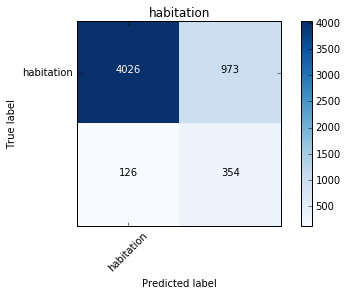

Stats for  habitation
Accuracy (true positive + true negative) / total:  0.799415951816
FPR (when actually no, how often does it say yes):  0.194638927786
TPR aka Recall (when actually yes, how often does it say yes):  0.7375
Precision (when predicts yes, how often is it right):  0.266767143934
Prevalence (how often does actual yes occur in sample):  0.0876072275963


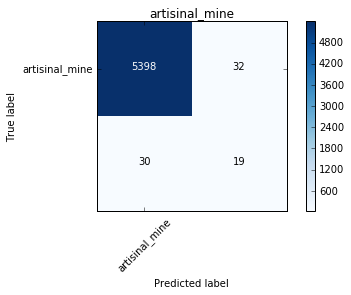

Stats for  artisinal_mine
Accuracy (true positive + true negative) / total:  0.988684066435
FPR (when actually no, how often does it say yes):  0.00589318600368
TPR aka Recall (when actually yes, how often does it say yes):  0.387755102041
Precision (when predicts yes, how often is it right):  0.372549019608
Prevalence (how often does actual yes occur in sample):  0.00894323781712


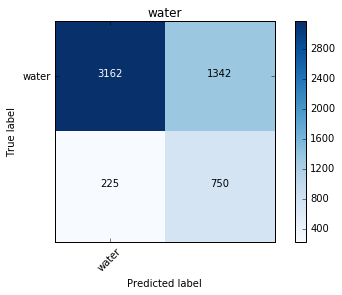

Stats for  water
Accuracy (true positive + true negative) / total:  0.71399890491
FPR (when actually no, how often does it say yes):  0.297957371226
TPR aka Recall (when actually yes, how often does it say yes):  0.769230769231
Precision (when predicts yes, how often is it right):  0.358508604207
Prevalence (how often does actual yes occur in sample):  0.177952181055


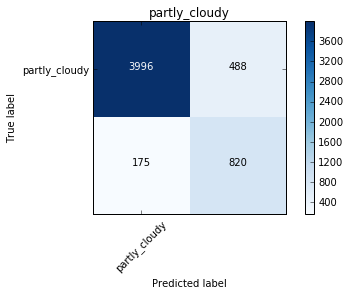

Stats for  partly_cloudy
Accuracy (true positive + true negative) / total:  0.878992516883
FPR (when actually no, how often does it say yes):  0.108831400535
TPR aka Recall (when actually yes, how often does it say yes):  0.824120603015
Precision (when predicts yes, how often is it right):  0.626911314985
Prevalence (how often does actual yes occur in sample):  0.181602482205


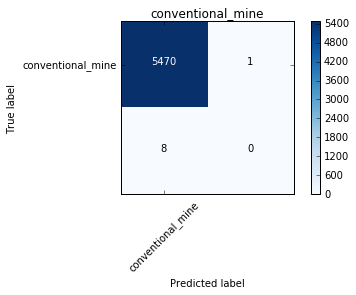

Stats for  conventional_mine
Accuracy (true positive + true negative) / total:  0.998357364483
FPR (when actually no, how often does it say yes):  0.000182781941144
TPR aka Recall (when actually yes, how often does it say yes):  0.0
Precision (when predicts yes, how often is it right):  0.0
Prevalence (how often does actual yes occur in sample):  0.00146012045994


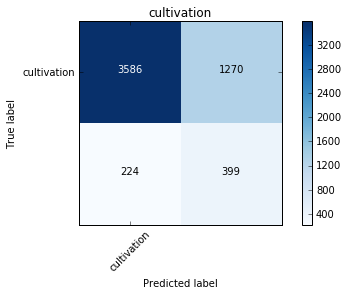

Stats for  cultivation
Accuracy (true positive + true negative) / total:  0.727322504107
FPR (when actually no, how often does it say yes):  0.261532125206
TPR aka Recall (when actually yes, how often does it say yes):  0.640449438202
Precision (when predicts yes, how often is it right):  0.239065308568
Prevalence (how often does actual yes occur in sample):  0.113706880818


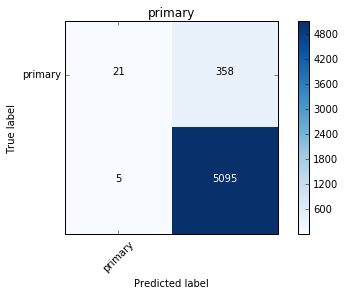

Stats for  primary
Accuracy (true positive + true negative) / total:  0.93374703413
FPR (when actually no, how often does it say yes):  0.944591029024
TPR aka Recall (when actually yes, how often does it say yes):  0.999019607843
Precision (when predicts yes, how often is it right):  0.934348065285
Prevalence (how often does actual yes occur in sample):  0.93082679321


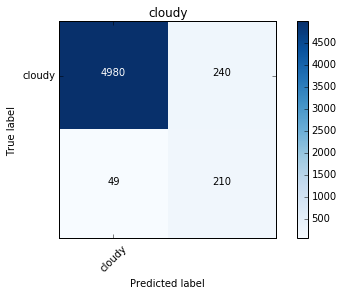

Stats for  cloudy
Accuracy (true positive + true negative) / total:  0.947253148385
FPR (when actually no, how often does it say yes):  0.0459770114943
TPR aka Recall (when actually yes, how often does it say yes):  0.810810810811
Precision (when predicts yes, how often is it right):  0.466666666667
Prevalence (how often does actual yes occur in sample):  0.0472713998905


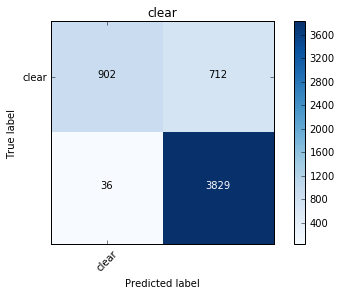

Stats for  clear
Accuracy (true positive + true negative) / total:  0.863478736996
FPR (when actually no, how often does it say yes):  0.441140024783
TPR aka Recall (when actually yes, how often does it say yes):  0.990685640362
Precision (when predicts yes, how often is it right):  0.843206342215
Prevalence (how often does actual yes occur in sample):  0.705420697208


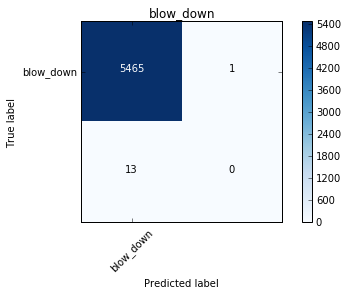

Stats for  blow_down
Accuracy (true positive + true negative) / total:  0.997444789195
FPR (when actually no, how often does it say yes):  0.000182949140139
TPR aka Recall (when actually yes, how often does it say yes):  0.0
Precision (when predicts yes, how often is it right):  0.0
Prevalence (how often does actual yes occur in sample):  0.0023726957474


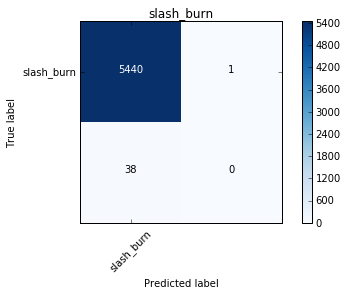

Stats for  slash_burn
Accuracy (true positive + true negative) / total:  0.992881912758
FPR (when actually no, how often does it say yes):  0.000183789744532
TPR aka Recall (when actually yes, how often does it say yes):  0.0
Precision (when predicts yes, how often is it right):  0.0
Prevalence (how often does actual yes occur in sample):  0.00693557218471


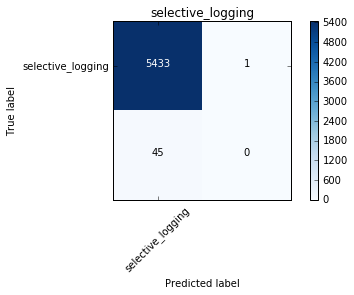

Stats for  selective_logging
Accuracy (true positive + true negative) / total:  0.991604307355
FPR (when actually no, how often does it say yes):  0.000184026499816
TPR aka Recall (when actually yes, how often does it say yes):  0.0
Precision (when predicts yes, how often is it right):  0.0
Prevalence (how often does actual yes occur in sample):  0.00821317758715


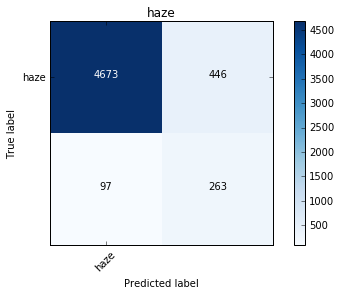

Stats for  haze
Accuracy (true positive + true negative) / total:  0.900894323782
FPR (when actually no, how often does it say yes):  0.0871263918734
TPR aka Recall (when actually yes, how often does it say yes):  0.730555555556
Precision (when predicts yes, how often is it right):  0.370944992948
Prevalence (how often does actual yes occur in sample):  0.0657054206972


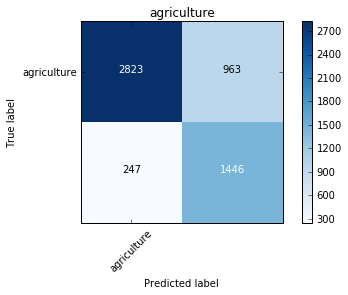

Stats for  agriculture
Accuracy (true positive + true negative) / total:  0.779156780434
FPR (when actually no, how often does it say yes):  0.254358161648
TPR aka Recall (when actually yes, how often does it say yes):  0.854105138807
Precision (when predicts yes, how often is it right):  0.600249066002
Prevalence (how often does actual yes occur in sample):  0.308997992334


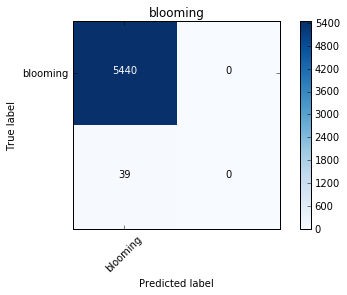

Stats for  blooming
Accuracy (true positive + true negative) / total:  0.992881912758
FPR (when actually no, how often does it say yes):  0.0
TPR aka Recall (when actually yes, how often does it say yes):  0.0
Precision (when predicts yes, how often is it right):  nan
Prevalence (how often does actual yes occur in sample):  0.0071180872422


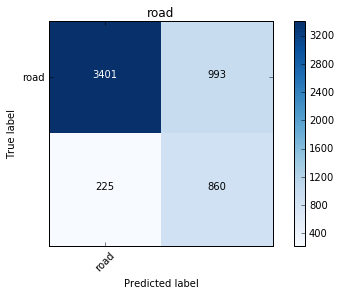

Stats for  road
Accuracy (true positive + true negative) / total:  0.777696659974
FPR (when actually no, how often does it say yes):  0.225989986345
TPR aka Recall (when actually yes, how often does it say yes):  0.792626728111
Precision (when predicts yes, how often is it right):  0.464112250405
Prevalence (how often does actual yes occur in sample):  0.198028837379


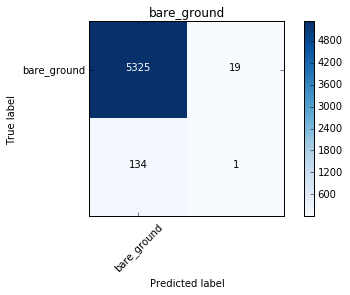

Stats for  bare_ground
Accuracy (true positive + true negative) / total:  0.972075196204
FPR (when actually no, how often does it say yes):  0.00355538922156
TPR aka Recall (when actually yes, how often does it say yes):  0.00740740740741
Precision (when predicts yes, how often is it right):  0.05
Prevalence (how often does actual yes occur in sample):  0.0246395327615


In [68]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



for i in inv_label_map.keys():
    label = inv_label_map[i]
    cnf_matrix = confusion_matrix(y_test[:,i], p_valid[:,i]>0.2)
    plot_confusion_matrix(cnf_matrix, classes=[label], normalize=False,
                      title=label)
    total = cnf_matrix[0][0] + cnf_matrix[0][1] + cnf_matrix[1][0] + cnf_matrix[1][1]
    actualYes = cnf_matrix[1][0] + cnf_matrix[1][1]
    actualNo = cnf_matrix[0][0] + cnf_matrix[0][1]
    predYes = cnf_matrix[0][1] + cnf_matrix[1][1]
    plt.show()
    print("Stats for ", label)
    print("Accuracy (true positive + true negative) / total: ", (cnf_matrix[1][1] + cnf_matrix[0][0])/total)
    print("FPR (when actually no, how often does it say yes): ", cnf_matrix[0][1]/actualNo)
    print("TPR aka Recall (when actually yes, how often does it say yes): ", cnf_matrix[1][1]/actualYes)
    print("Precision (when predicts yes, how often is it right): ", cnf_matrix[1][1]/predYes)
    print("Prevalence (how often does actual yes occur in sample): ", actualYes/total)

